# 1.Neural Network and Deep Learning

## 1.5Deep Neural Network for Image Classification: Application

In [158]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *
from testCases_v2 import *

#matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
#load_ext autoreload
#autoreload 2
np.random.seed(1)

In [159]:
train_x_orig,train_y,test_x_orig,test_y,classes = load_data()

y=0. It's a non-cat picture.


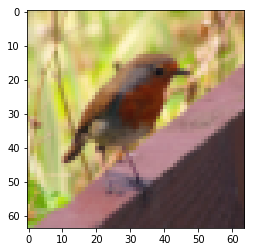

In [160]:
index = 10
plt.imshow(train_x_orig[index])
print("y=" + str(train_y[0,index])+". It's a " + classes[train_y[0,index]].decode("utf-8")+" picture.")

In [161]:
m_train =train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

In [162]:
def initialize_parameters(n_x,n_h,n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    assert(W1.shape == (n_h,n_x))
    assert(b1.shape == (n_h,1))
    assert(W2.shape == (n_y,n_h))
    assert(b2.shape == (n_y,1))
    
    parameters = {"W1":W1,
                  "b1":b1,
                  "W2":W2,
                  "b2":b2}
    return parameters

In [163]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters["W"+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters["b"+str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [164]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [165]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (￿ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (￿ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [166]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters)
    
    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation = "relu" )
        caches.append(cache)
        
    AL,cache = linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],activation = "sigmoid" )
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches

In [167]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    # Compute loss from aL and y.
    ### START CODE HERE ### (￿ 1 lines of code)
    cost = -(np.dot(Y,np.log(AL.T))+np.dot(1-Y,np.log(1-AL).T))/m
    ### END CODE HERE ###
    
    cost = np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

In [168]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    ### START CODE HERE ### (￿ 3 lines of code)
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [169]:
def linear_activation_backward(dA, cache, activation):
    linear_cache,activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
        
    return dA_prev,dW,db

In [170]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)],current_cache, "relu")

        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [171]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] -learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] -learning_rate * grads["db" + str(l + 1)]

    return parameters

In [172]:
def two_layer_model(X,Y,layers_dims,learning_rate = 0.0075,num_iterations = 3000,print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x,n_h,n_y) = layers_dims
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0,num_iterations):
        A1,cache1 = linear_activation_forward(X,W1,b1,"relu")
        A2,cache2 = linear_activation_forward(A1,W2,b2,"sigmoid")
        
        cost = compute_cost(A2,Y)
        
        dA2 = -(np.divide(Y,A2) - np.divide(1-Y,1-A2))
        
        dA1,dW2,db2 = linear_activation_backward(dA2,cache2,"sigmoid")
        dA0,dW1,db1 = linear_activation_backward(dA1,cache1,"relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads,learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i,np.squeeze(cost)))
            
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [173]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.40079775362038866
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962654
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.2468176821061485
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556635
Cost after iteration 1600: 0.1708076297809714
Cost after iteration 1700: 0.11306524562164709
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319085
Cost after iteration 2100: 0.0663074813

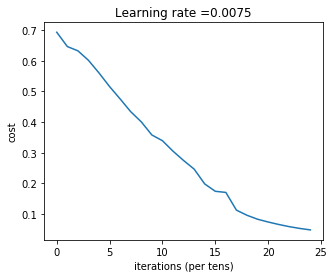

In [174]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T/255
paremeters = two_layer_model(train_x,train_y,layers_dims = (n_x,n_h,n_y),num_iterations = 2500,print_cost = True)

In [177]:
pred_train = predict(train_x, train_y, paremeters)

Accuracy: 0.9999999999999998


In [180]:
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1).T/255
pred_test = predict(test_x, test_y, paremeters)

Accuracy: 0.72


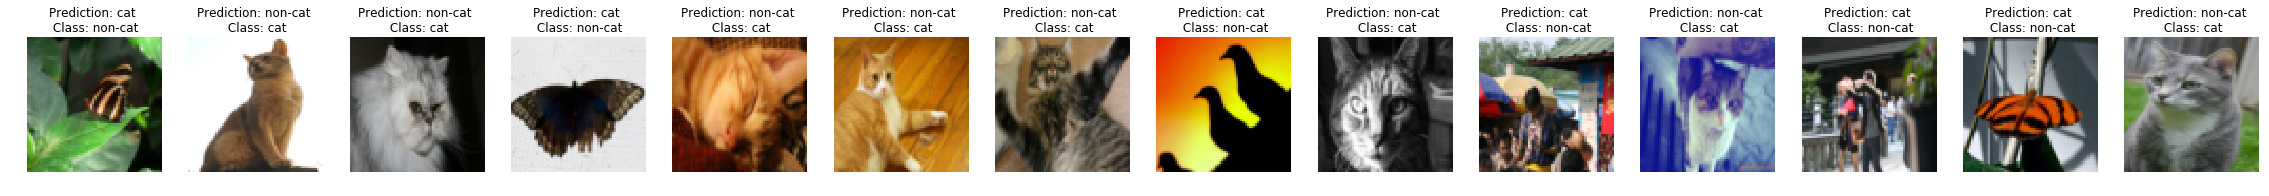

In [183]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

G:\anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
G:\anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


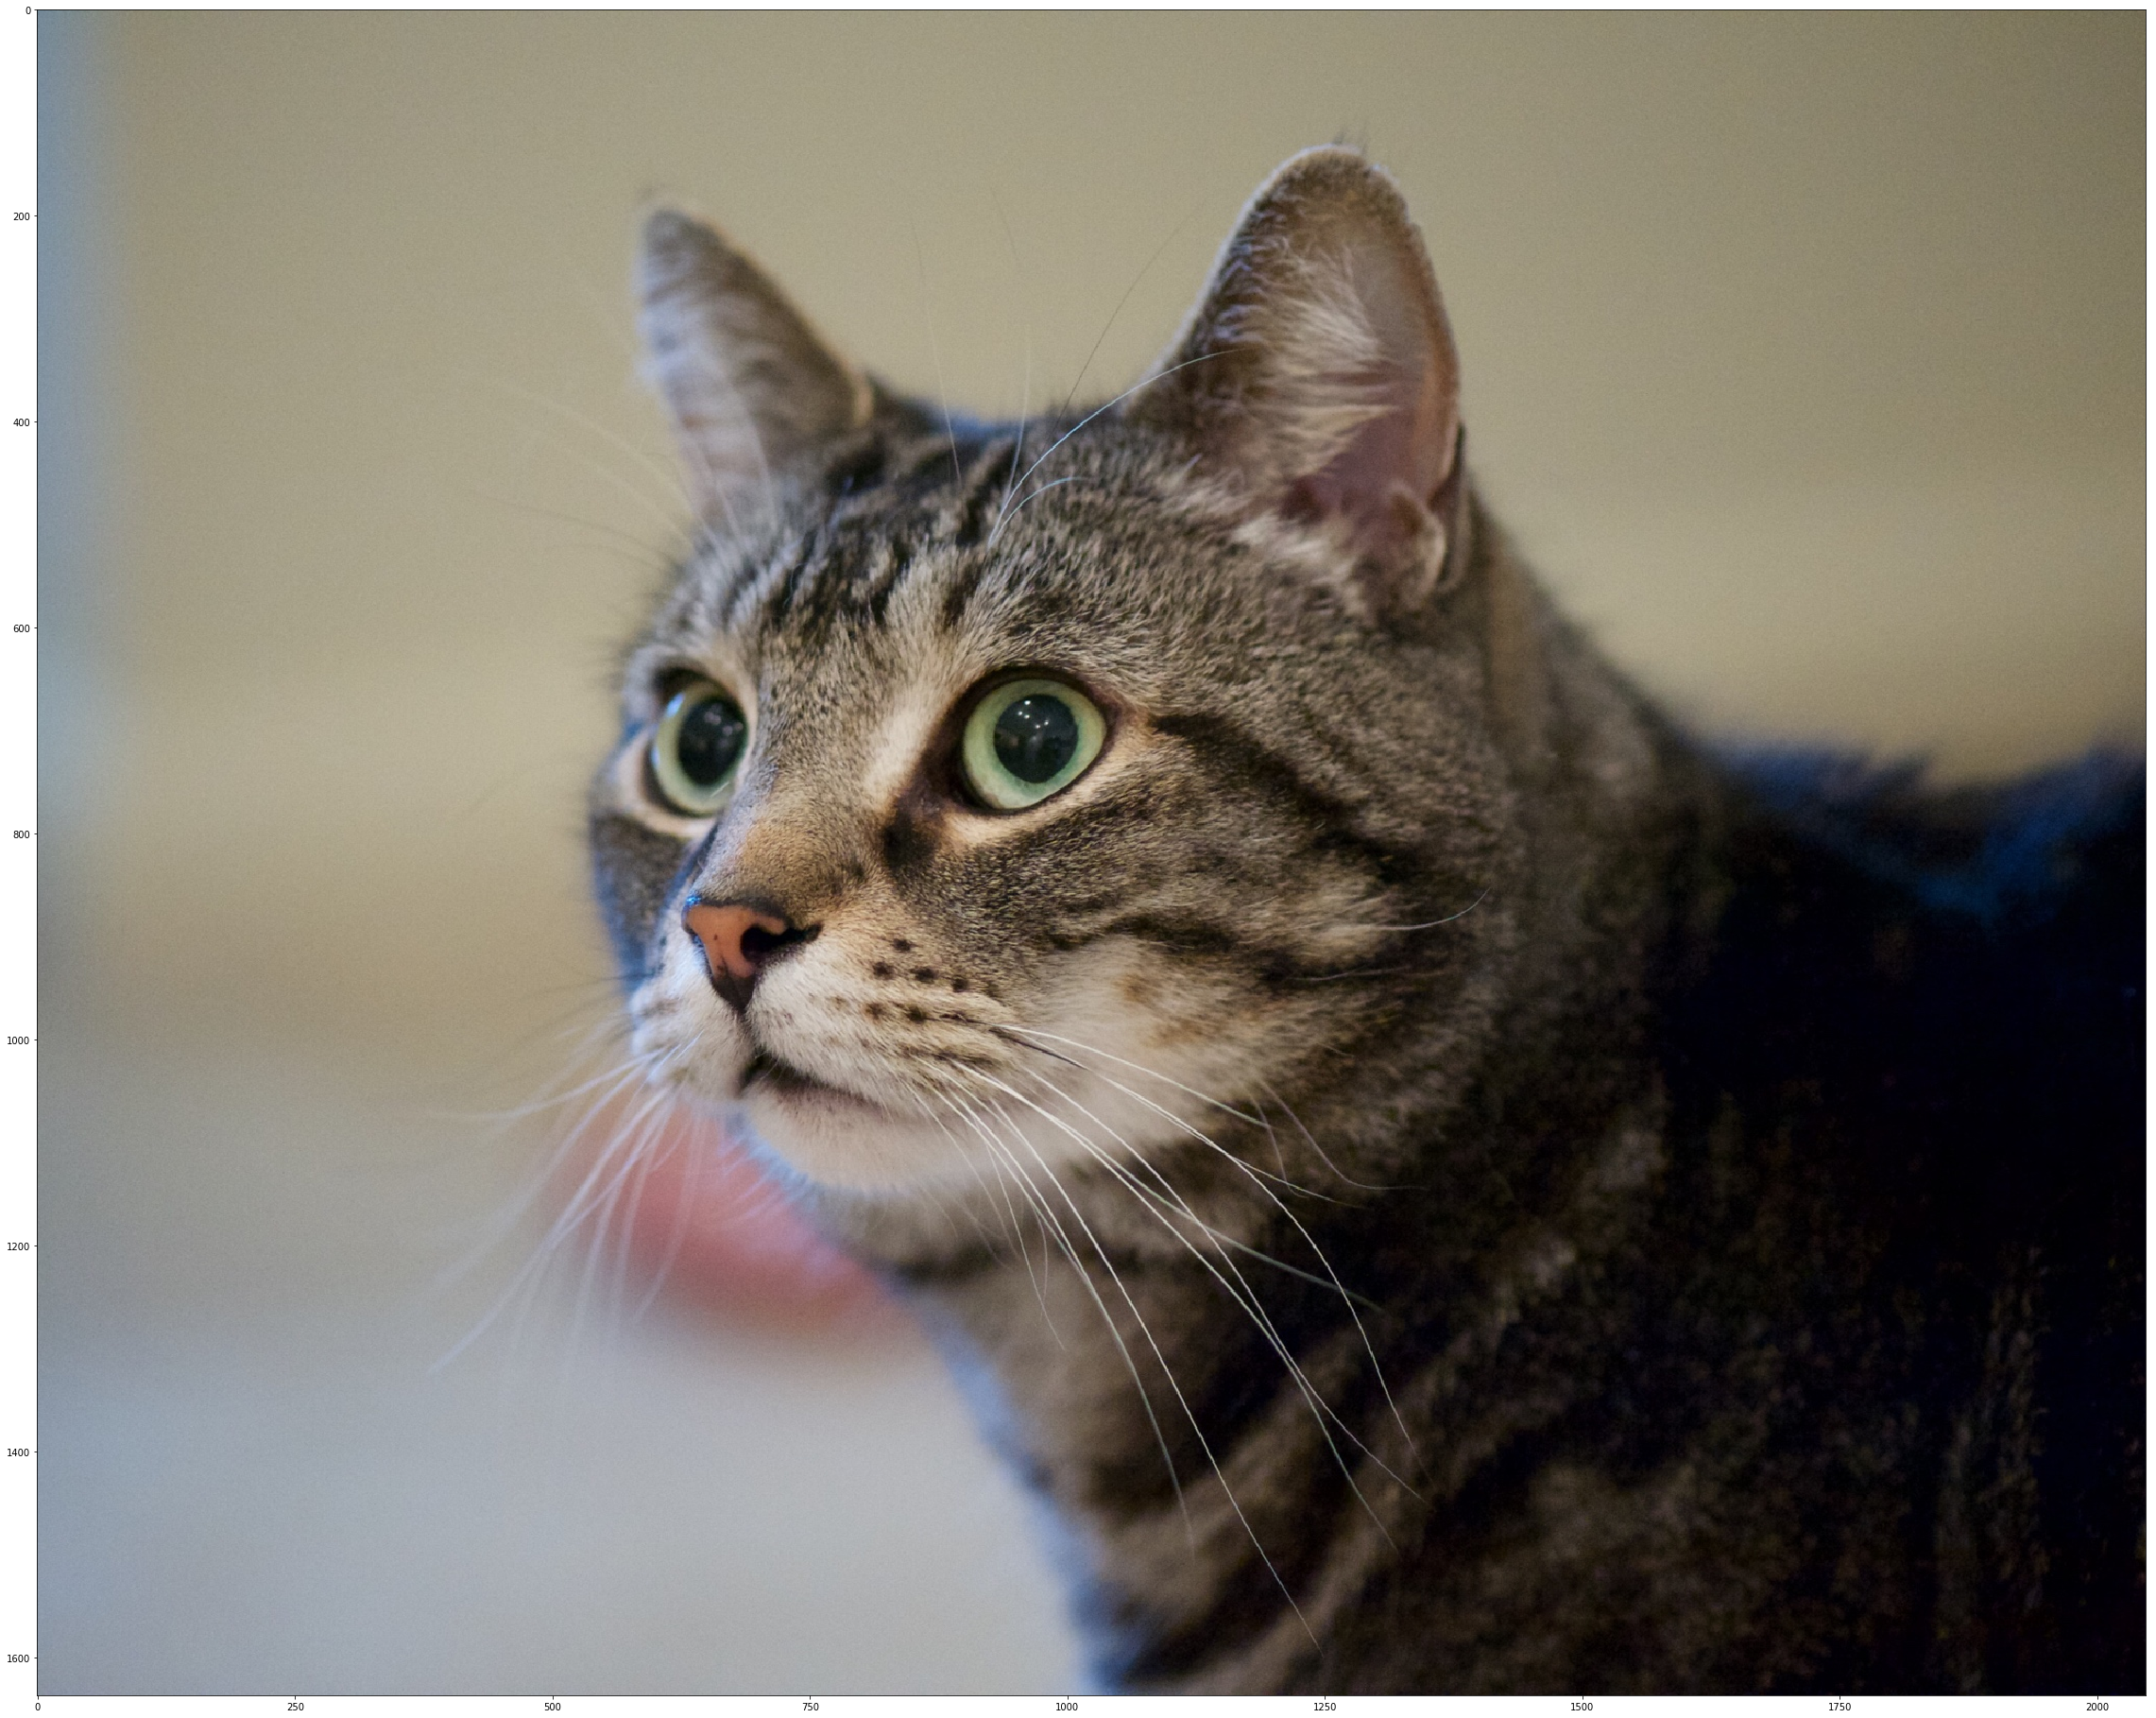

In [185]:
my_image = "cat_test.jpg" # change this to the name of your image file
my_label_y = [1] # the true class of your image (1 -> cat, 0 ->non-cat)
## END CODE HERE ##

fname = "./" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image,size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, paremeters)
plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +"\" picture.")